In [485]:
from __future__ import unicode_literals
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import data_utils as dutils
from pathlib import Path
from datetime import datetime, timedelta
from sklearn.linear_model import BayesianRidge, LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, ShuffleSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

plt.style.use("fivethirtyeight")

%matplotlib inline
import warnings
warnings.filterwarnings(action='once')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [458]:
# def rmse(x,y): return math.sqrt(((x-y)**2).mean())

# def get_score(m, X_val, y_val):
#     res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_val), y_val),
#                 m.score(X_train, y_train), m.score(X_val, y_val)]
#     print(f"RMSE Train: {res[0]} | RMSE Test: {res[1]} \n R2 Train: {res[2]} | R2 Test: {res[3]}")
#     return res

In [459]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def get_score(m, X_val, y_val):
    res = [rmse(m.predict(X_val), y_val), m.score(X_val, y_val)]
    print(f"RMSE: {res[0]} | R2: {res[1]}")
    return res

In [266]:
def plot(SVR_m, RF_m, bayes_m, LR_m, X_val, y_val, X_train = [], y_train = [],full=False):
    if full == True:
        data = X_train.append(X_val)
        target = list(y_train)
        y_val = list(y_val)
        target.extend(y_val)
    else: 
        target = y_val
        data = X_val
    pltdata = pd.DataFrame({"Target": target}, index=data.index)
    pltdata["SVR"] = SVR_m.predict(data)
    pltdata["Bayes"] = bayes_m.predict(data)
    pltdata["LR"] = LR_m.predict(data)
    pltdata["RF"] = RF_m.predict(data)
    pltdata.plot(style='.-', figsize=(16,8), title='Close Price History')

In [331]:
def getTrainTestData(perc=0.75, normalize=False):
    df = dutils.loadData()
    return dutils.getTrainTestSets(df, perc=perc, normalize=normalize)

In [424]:
def trainSVR(X_train, y_train, parameters=None):
    if parameters == None:
        parameters = {
            "kernel": ["rbf", "sigmoid"],
            "C": [1,10,10,100,1000],
            "gamma": [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1],
            "epsilon": [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
        }
        cv = ShuffleSplit(test_size=0.01, n_splits=1)
        grid = GridSearchCV(SVR(), parameters, cv=cv, verbose=0, return_train_score=True)
        grid.fit(X_train, y_train)
        return grid.best_estimator_
    new_model = SVR(kernel=parameters["kernel"], C=parameters["C"], gamma=parameters["gamma"], epsilon=parameters["epsilon"])
    new_model.fit(X_train, y_train)
    return new_model

In [404]:
def trainRF(X_train, y_train, parameters=None):
    estimators = range(1, 20)
    leaves = range(1,40)
    if parameters == None:
        parameters = {
            "n_estimators": estimators,
            "min_samples_leaf": leaves,
        }
        cv = ShuffleSplit(test_size=0.01, n_splits=1)
        grid = GridSearchCV(RandomForestRegressor(bootstrap=True), parameters, cv=cv, verbose=0, return_train_score=True)
        grid.fit(X_train, y_train)
        return grid.best_estimator_
    new_model = RandomForestRegressor(bootstrap=True, n_estimators=parameters["n_estimators"], min_samples_leaf=parameters["min_samples_leaf"])
    new_model.fit(X_train, y_train)
    return new_model

In [405]:
def trainBayes(X_train, y_train, parameters=None):
    clf = BayesianRidge(compute_score=True)
    if parameters == None:
        parameters = {
            "n_iter": [15, 60, 150, 250, 300],
            "alpha_1": [1e-7, 1e-6, 1e-5, 1e-4, 1e-3],
            "alpha_2": [1e-7, 1e-6, 1e-5, 1e-4, 1e-3],
            "lambda_1": [1e-7, 1e-6, 1e-5, 1e-4, 1e-3],
            "lambda_2": [1e-7, 1e-6, 1e-5, 1e-4, 1e-3],    
        }
        cv = ShuffleSplit(test_size=0.01, n_splits=1)
        grid = GridSearchCV(BayesianRidge(compute_score=True, copy_X=True), parameters, cv=cv, verbose=0, return_train_score=True)
        grid.fit(X_train, y_train)
        return grid.best_estimator_
    new_model = BayesianRidge(compute_score=True, copy_X=True, n_iter=parameters["n_iter"], alpha_1=parameters["alpha_1"], alpha_2=parameters["alpha_2"], lambda_1=parameters["lambda_1"], lambda_2=parameters["lambda_2"])
    new_model.fit(X_train, y_train)
    return new_model

In [390]:
def trainLR(X_train, y_train):
    reg = LinearRegression(copy_X=True)
    reg.fit(X_train, y_train)
    return reg

In [348]:
def getResults(SVR_m, RF_m, bayes_m, LR_m, X_val, y_val):
    results = {}
    print(f"SVR Score: ")
    results["SVR"] = get_score(SVR_m, X_val, y_val)
    print(f"\nRF Score: ")
    results["RF"] = get_score(RF_m, X_val, y_val)
    print(f"\nBayes Score: ")
    results["Bayes"] = get_score(bayes_m, X_val, y_val)
    print(f"\nLR Score: ")
    results["LR"] = get_score(LR_m, X_val, y_val)    
    return results

In [189]:
def getTrainedModels(X_train, y_train):
    SVR_m = trainSVR(X_train, y_train)
    RF_m = trainRF(X_train, y_train)
    bayes_m = trainBayes(X_train, y_train)
    LR_m = trainLR(X_train, y_train)
    return SVR_m, RF_m, bayes_m, LR_m

In [378]:
def trainModel(percent, normalize=False):
    print(f"\n Training with split: {percent * 100}% \n")
    X_train, y_train, X_val, y_val = getTrainTestData(perc=percent, normalize=normalize)
    SVR_m, RF_m, bayes_m, LR_m = getTrainedModels(X_train, y_train)
    plot(SVR_m, RF_m, bayes_m, LR_m, X_val, y_val)
    results = {}
    print(f"SVR Score: ")
    results["SVR"] = get_score(SVR_m, X_val, y_val)
    print(f"\nRF Score: ")
    results["RF"] = get_score(RF_m, X_val, y_val)
    print(f"\nBayes Score: ")
    results["Bayes"] = get_score(bayes_m, X_val, y_val)
    print(f"\nLR Score: ")
    results["LR"] = get_score(LR_m, X_val, y_val) 
    return results

In [416]:
import json
def saveResults(results, name):
    with open(f'{name}.json', 'w') as fp:
        json.dump(results, fp)

In [332]:
def getTrainTestDataWithEmotion(perc=0.75, normalize=False):
    df = dutils.loadData()
    emo_df = dutils.loadEmoData()
    emo_df.fillna(0, inplace=True)
    mergedDf = df.merge(emo_df, right_index=True, left_index=True)
    return dutils.getTrainTestSets(mergedDf, perc=perc, with_emotions=True, normalize=normalize)

In [374]:
def trainEmoModel(percent, normalize=False):
    print(f"\n Training with split: {percent * 100}% \n")
    X_train, y_train, X_val, y_val = getTrainTestDataWithEmotion(perc=percent, normalize=normalize)
    SVR_m, RF_m, bayes_m, LR_m = getTrainedModels(X_train, y_train)
    plot(SVR_m, RF_m, bayes_m, LR_m, X_val, y_val)
    results = {}
    print(f"SVR Score: ")
    results["SVR"] = get_score(SVR_m, X_val, y_val)
    print(f"\nRF Score: ")
    results["RF"] = get_score(RF_m, X_val, y_val)
    print(f"\nBayes Score: ")
    results["Bayes"] = get_score(bayes_m, X_val, y_val)
    print(f"\nLR Score: ")
    results["LR"] = get_score(LR_m, X_val, y_val)  
    return results

In [536]:
FEATURES = ['PREABE','PREMAX','PREMIN','PREMED','PREOFC','PREOFV', 'PREULT']
df = dutils.loadData()[FEATURES]
df.describe()

,PREABE,PREMAX,PREMIN,PREMED,PREOFC,PREOFV,PREULT
count,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000
mean,93.874138,94.913534,92.656767,93.771509,93.739828,93.806810,93.769397
std,12.618101,12.328683,13.005627,12.666318,12.699059,12.686205,12.703585
min,62.900000,66.300000,59.100000,61.530000,61.130000,61.140000,61.140000
25%,87.092500,88.695000,85.475000,86.932500,88.402500,88.422500,88.417500
50%,95.475000,96.810000,95.005000,95.920000,95.765000,95.795000,95.765000
75%,100.870000,101.782500,99.862500,100.855000,100.882500,100.917500,100.917500
max,115.210000,115.260000,113.710000,114.210000,115.210000,115.240000,115.210000


# Train -  No emotion first

SVR No Emo No Normalize Score: 
RMSE: 6.567287943620983 | R2: -1.1781753676327358

RF No Emo No Normalize Score: 
RMSE: 3.420116542199115 | R2: 0.4092516247762319

Bayes No Emo No Normalize Score: 
RMSE: 1.5377815170589133 | R2: 0.8805709441348393

LR No Emo No Normalize Score: 
RMSE: 1.5402675396570673 | R2: 0.8801844869954242


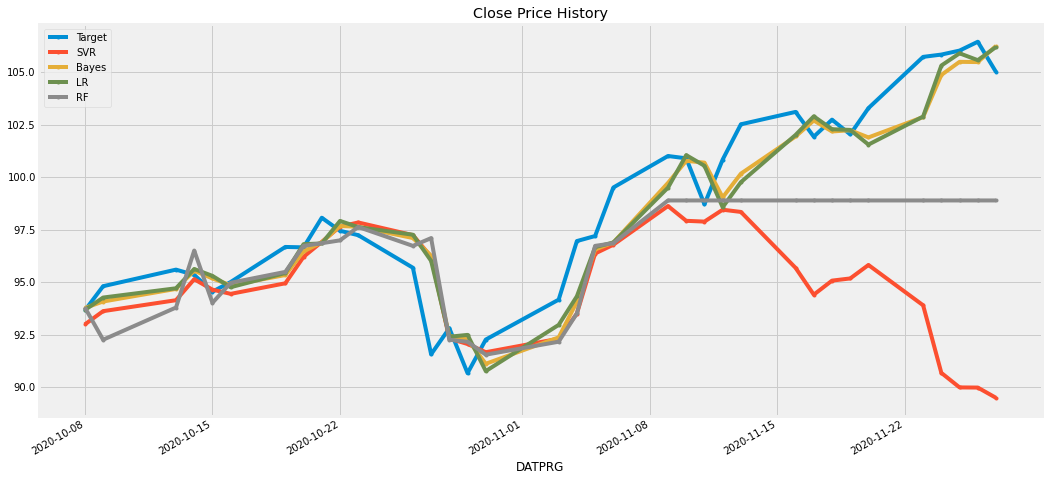

In [531]:
results = {}
# No emo No Normalize
X_train, y_train, X_val, y_val, scaler = getTrainTestData(perc=0.75, normalize=False)
SVR_m = trainSVR(X_train, y_train)
RF_m = trainRF(X_train, y_train)
bayes_m = trainBayes(X_train, y_train)
LR_m = trainLR(X_train, y_train)
results_no_no = {}
print(f"SVR No Emo No Normalize Score: ")
results_no_no["SVR"] = get_score(SVR_m, X_val, y_val)
print(f"\nRF No Emo No Normalize Score: ")
results_no_no["RF"] = get_score(RF_m, X_val, y_val)
print(f"\nBayes No Emo No Normalize Score: ")
results_no_no["Bayes"] = get_score(bayes_m, X_val, y_val)
print(f"\nLR No Emo No Normalize Score: ")
results_no_no["LR"] = get_score(LR_m, X_val, y_val) 
results["NN"] = results_no_no
plot(SVR_m, RF_m, bayes_m, LR_m, X_val, y_val)

SVR Yes Emo No Normalize Score: 
RMSE: 6.567335686413633 | R2: -1.1782070374951896

RF Yes Emo No Normalize Score: 
RMSE: 3.3592043895311385 | R2: 0.43010665710422835

Bayes Yes Emo No Normalize Score: 
RMSE: 1.5378308137185281 | R2: 0.8805632869380049

LR Yes Emo No Normalize Score: 
RMSE: 1.7953914981064143 | R2: 0.8372057526448482


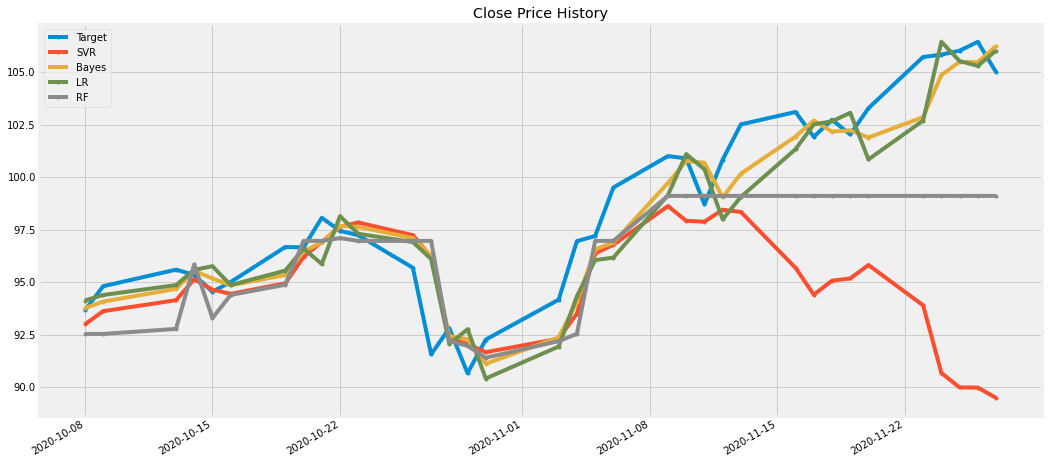

In [532]:
# Yes emo No Normalize
X_train, y_train, X_val, y_val, scaler = getTrainTestDataWithEmotion(perc=0.75, normalize=False)
SVR_m = trainSVR(X_train, y_train, SVR_m.get_params())
RF_m = trainRF(X_train, y_train, RF_m.get_params())
bayes_m = trainBayes(X_train, y_train, bayes_m.get_params())
LR_m = trainLR(X_train, y_train)
results_yes_no = {}
print(f"SVR Yes Emo No Normalize Score: ")
results_yes_no["SVR"] = get_score(SVR_m, X_val, y_val)
print(f"\nRF Yes Emo No Normalize Score: ")
results_yes_no["RF"] = get_score(RF_m, X_val, y_val)
print(f"\nBayes Yes Emo No Normalize Score: ")
results_yes_no["Bayes"] = get_score(bayes_m, X_val, y_val)
print(f"\nLR Yes Emo No Normalize Score: ")
results_yes_no["LR"] = get_score(LR_m, X_val, y_val)
results["YN"] = results_yes_no
plot(SVR_m, RF_m, bayes_m, LR_m, X_val, y_val)

SVR No Emo Yes Normalize Score: 
RMSE: 1.876016260289314 | R2: 0.6998320181220878

RF No Emo Yes Normalize Score: 
RMSE: 3.082791468812694 | R2: -0.19916465420016616

Bayes No Emo Yes Normalize Score: 
RMSE: 1.3899250145841324 | R2: 0.8875130188372621

LR No Emo Yes Normalize Score: 
RMSE: 10.239967133874906 | R2: -0.06331808566261543


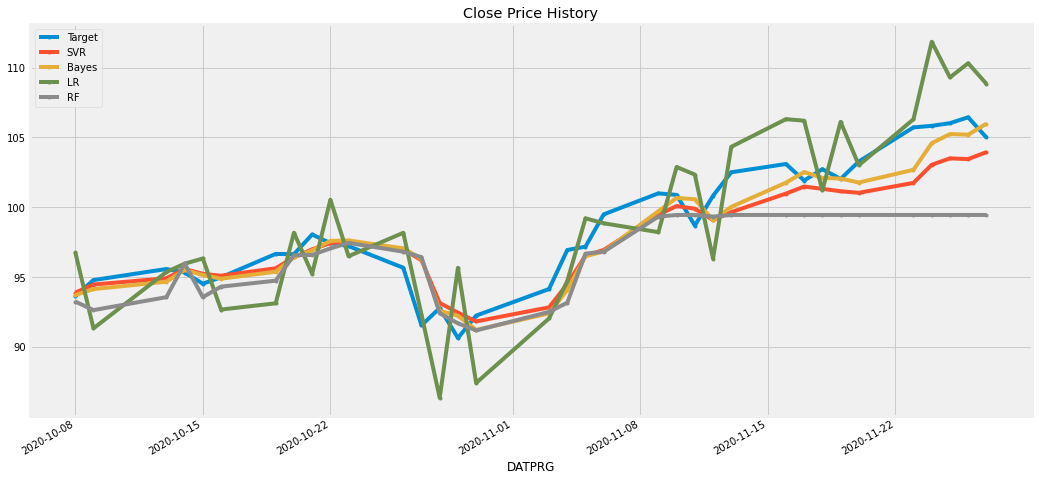

In [533]:
# No emo Yes Normalize
X_train, y_train, X_val, y_val, scaler = getTrainTestData(perc=0.75, normalize=True)

SVR_m = trainSVR(X_train, y_train)
RF_m = trainRF(X_train, y_train)
bayes_m = trainBayes(X_train, y_train)
LR_m = trainLR(X_train, y_train)

results_no_yes = {}
print(f"SVR No Emo Yes Normalize Score: ")
results_no_yes["SVR"] = get_score_unscaled(SVR_m, X_val, y_val, scaler)
print(f"\nRF No Emo Yes Normalize Score: ")
results_no_yes["RF"] = get_score_unscaled(RF_m, X_val, y_val, scaler)
print(f"\nBayes No Emo Yes Normalize Score: ")
results_no_yes["Bayes"] = get_score_unscaled(bayes_m, X_val, y_val, scaler)
print(f"\nLR No Emo Yes Normalize Score: ")
results_no_yes["LR"] = get_score_unscaled(LR_m, X_val, y_val, scaler) 
results["NY"] = results_no_yes
plot_unscaled(SVR_m, RF_m, bayes_m, LR_m, X_val, y_val, scaler)

SVR Yes Emo Yes Normalize Score: 
RMSE: 1.7129211979900536 | R2: 0.7839452802162353

RF Yes Emo Yes Normalize Score: 
RMSE: 3.060909205212353 | R2: -0.2873272502807276

Bayes Yes Emo Yes Normalize Score: 
RMSE: 1.4042019467815157 | R2: 0.8854771395552364

LR Yes Emo Yes Normalize Score: 
RMSE: 9.14764829146448 | R2: -0.04317731597638996


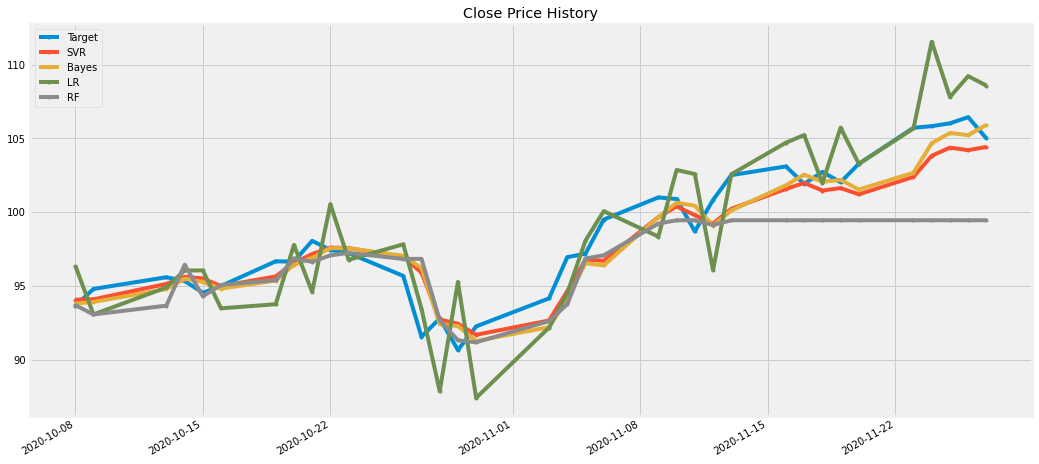

In [534]:
# Yes emo Yes Normalize
X_train, y_train, X_val, y_val, scaler = getTrainTestDataWithEmotion(perc=0.75, normalize=True)
SVR_m = trainSVR(X_train, y_train, SVR_m.get_params())
RF_m = trainRF(X_train, y_train, RF_m.get_params())
bayes_m = trainBayes(X_train, y_train, bayes_m.get_params())
LR_m = trainLR(X_train, y_train)
results_yes_yes = {}
print(f"SVR Yes Emo Yes Normalize Score: ")
results_yes_yes["SVR"] = get_score_unscaled(SVR_m, X_val, y_val, scaler)
print(f"\nRF Yes Emo Yes Normalize Score: ")
results_yes_yes["RF"] = get_score_unscaled(RF_m, X_val, y_val, scaler)
print(f"\nBayes Yes Emo Yes Normalize Score: ")
results_yes_yes["Bayes"] = get_score_unscaled(bayes_m, X_val, y_val, scaler)
print(f"\nLR Yes Emo Yes Normalize Score: ")
results_yes_yes["LR"] = get_score_unscaled(LR_m, X_val, y_val, scaler)
results["YY"] = results_yes_yes
plot_unscaled(SVR_m, RF_m, bayes_m, LR_m, X_val, y_val, scaler)

In [417]:
saveResults(results, name="NE_first_result")

# Train - Yes emotion first

SVR Yes Emo No Normalize Score: 
RMSE: 2.9778936422312947 | R2: 0.552143284566128

RF Yes Emo No Normalize Score: 
RMSE: 2.902601911586025 | R2: 0.5745038062381372

Bayes Yes Emo No Normalize Score: 
RMSE: 1.5377841147416609 | R2: 0.8805705406457134

LR Yes Emo No Normalize Score: 
RMSE: 1.7953914981064143 | R2: 0.8372057526448482


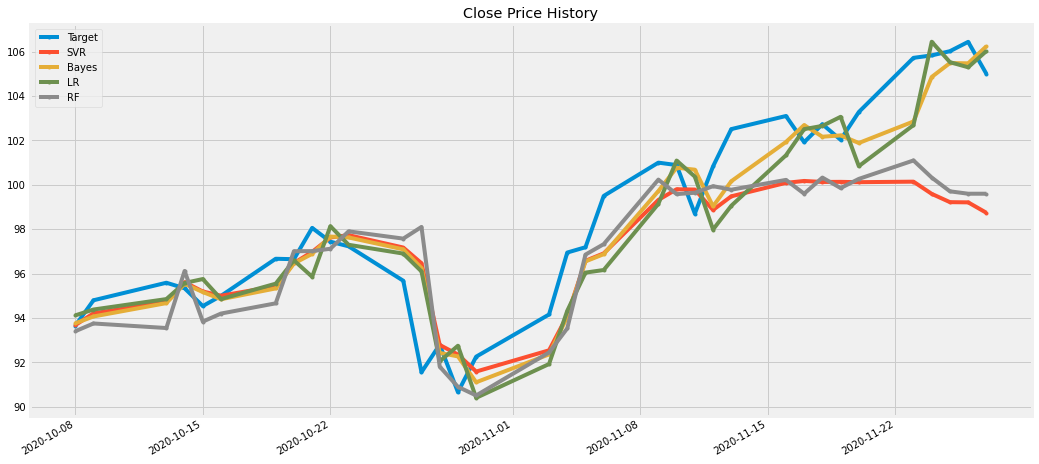

In [529]:
results = {}
# Yes emo No Normalize
X_train, y_train, X_val, y_val, scaler = getTrainTestDataWithEmotion(perc=0.75, normalize=False)
SVR_m = trainSVR(X_train, y_train)
RF_m = trainRF(X_train, y_train)
bayes_m = trainBayes(X_train, y_train)
LR_m = trainLR(X_train, y_train)
results_yes_no = {}
print(f"SVR Yes Emo No Normalize Score: ")
results_yes_no["SVR"] = get_score(SVR_m, X_val, y_val)
print(f"\nRF Yes Emo No Normalize Score: ")
results_yes_no["RF"] = get_score(RF_m, X_val, y_val)
print(f"\nBayes Yes Emo No Normalize Score: ")
results_yes_no["Bayes"] = get_score(bayes_m, X_val, y_val)
print(f"\nLR Yes Emo No Normalize Score: ")
results_yes_no["LR"] = get_score(LR_m, X_val, y_val)
results["YN"] = results_yes_no
plot(SVR_m, RF_m, bayes_m, LR_m, X_val, y_val)

SVR No Emo No Normalize Score: 
RMSE: 2.9790446828319 | R2: 0.5517969989343263

RF No Emo No Normalize Score: 
RMSE: 2.4285562289440272 | R2: 0.7021366619996576

Bayes No Emo No Normalize Score: 
RMSE: 1.5377342017545084 | R2: 0.8805782933390488

LR No Emo No Normalize Score: 
RMSE: 1.5402675396570673 | R2: 0.8801844869954242


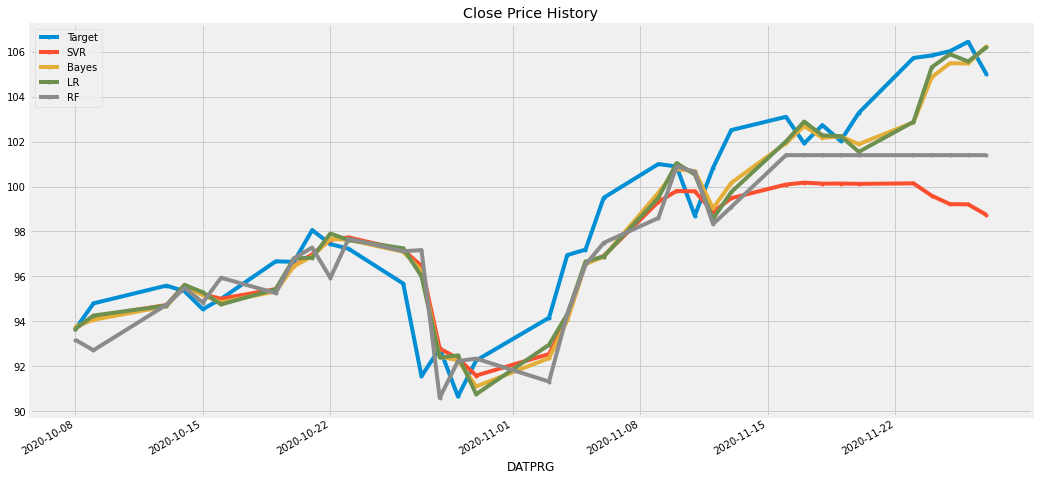

In [530]:
# No emo No Normalize
X_train, y_train, X_val, y_val, scaler = getTrainTestData(perc=0.75, normalize=False)
SVR_m = trainSVR(X_train, y_train, SVR_m.get_params())
RF_m = trainRF(X_train, y_train, RF_m.get_params())
bayes_m = trainBayes(X_train, y_train, bayes_m.get_params())
LR_m = trainLR(X_train, y_train)
results_no_no = {}
print(f"SVR No Emo No Normalize Score: ")
results_no_no["SVR"] = get_score(SVR_m, X_val, y_val)
print(f"\nRF No Emo No Normalize Score: ")
results_no_no["RF"] = get_score(RF_m, X_val, y_val)
print(f"\nBayes No Emo No Normalize Score: ")
results_no_no["Bayes"] = get_score(bayes_m, X_val, y_val)
print(f"\nLR No Emo No Normalize Score: ")
results_no_no["LR"] = get_score(LR_m, X_val, y_val) 
results["NN"] = results_no_no
plot(SVR_m, RF_m, bayes_m, LR_m, X_val, y_val)

SVR Yes Emo Yes Normalize Score: 
RMSE: 2.289669178690041 | R2: 0.5950523933477643

RF Yes Emo Yes Normalize Score: 
RMSE: 3.2582141782543483 | R2: -0.23455184782655647

Bayes Yes Emo Yes Normalize Score: 
RMSE: 1.4042019467815157 | R2: 0.8854771395552364

LR Yes Emo Yes Normalize Score: 
RMSE: 9.14764829146448 | R2: -0.04317731597638996


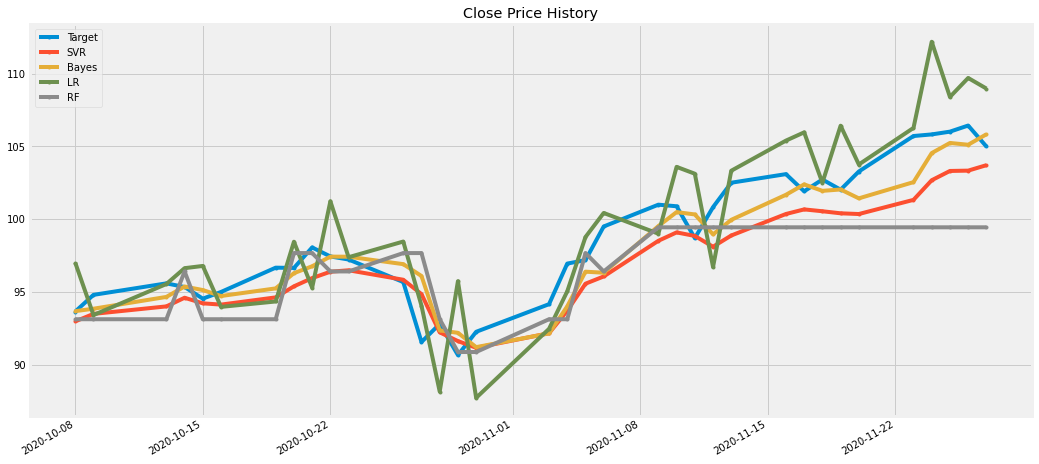

In [526]:
# Yes emo Yes Normalize
X_train, y_train, X_val, y_val, scaler = getTrainTestDataWithEmotion(perc=0.75, normalize=True)
SVR_m = trainSVR(X_train, y_train)
RF_m = trainRF(X_train, y_train)
bayes_m = trainBayes(X_train, y_train)
LR_m = trainLR(X_train, y_train)
results_yes_yes = {}
print(f"SVR Yes Emo Yes Normalize Score: ")
results_yes_yes["SVR"] = get_score_unscaled(SVR_m, X_val, y_val, scaler)
print(f"\nRF Yes Emo Yes Normalize Score: ")
results_yes_yes["RF"] = get_score_unscaled(RF_m, X_val, y_val, scaler)
print(f"\nBayes Yes Emo Yes Normalize Score: ")
results_yes_yes["Bayes"] = get_score_unscaled(bayes_m, X_val, y_val, scaler)
print(f"\nLR Yes Emo Yes Normalize Score: ")
results_yes_yes["LR"] = get_score_unscaled(LR_m, X_val, y_val, scaler)
results["YY"] = results_yes_yes
plot_unscaled(SVR_m, RF_m, bayes_m, LR_m, X_val, y_val, scaler)

SVR No Emo Yes Normalize Score: 
RMSE: 4.287034098675716 | R2: -1.439894756667063

RF No Emo Yes Normalize Score: 
RMSE: 2.905431066638846 | R2: -0.032592298830717015

Bayes No Emo Yes Normalize Score: 
RMSE: 1.3899250145841324 | R2: 0.8875130188372621

LR No Emo Yes Normalize Score: 
RMSE: 10.239967133874906 | R2: -0.06331808566261543


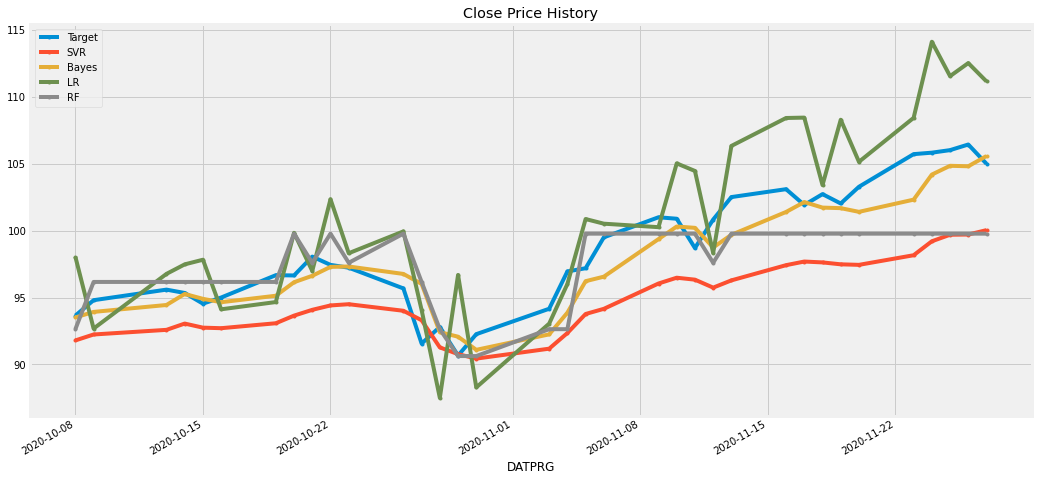

In [528]:
# No emo Yes Normalize
X_train, y_train, X_val, y_val, scaler = getTrainTestData(perc=0.75, normalize=True)

SVR_m = trainSVR(X_train, y_train, SVR_m.get_params())
RF_m = trainRF(X_train, y_train, RF_m.get_params())
bayes_m = trainBayes(X_train, y_train, bayes_m.get_params())
LR_m = trainLR(X_train, y_train)

results_no_yes = {}
print(f"SVR No Emo Yes Normalize Score: ")
results_no_yes["SVR"] = get_score_unscaled(SVR_m, X_val, y_val, scaler)
print(f"\nRF No Emo Yes Normalize Score: ")
results_no_yes["RF"] = get_score_unscaled(RF_m, X_val, y_val, scaler)
print(f"\nBayes No Emo Yes Normalize Score: ")
results_no_yes["Bayes"] = get_score_unscaled(bayes_m, X_val, y_val, scaler)
print(f"\nLR No Emo Yes Normalize Score: ")
results_no_yes["LR"] = get_score_unscaled(LR_m, X_val, y_val, scaler) 
results["NY"] = results_no_yes
plot_unscaled(SVR_m, RF_m, bayes_m, LR_m, X_val, y_val, scaler)

In [427]:
saveResults(results, name="YE_first_result")

In [523]:
def plot_unscaled(SVR_m, RF_m, bayes_m, LR_m, X_val, y_val, scaler, X_train = [], y_train = [],full=False):
    if full == True:
        data = X_train.append(X_val)        
        y_val = list(y_val)
        target = list(y_train).extend(y_val)    
    else: 
        target = y_val
        data = X_val
    
    FEATURES = ['PREABE','PREMAX','PREMIN','PREMED','PREOFC','PREOFV', 'PREULT']
    
    target_df = data
    target_df['PREULT'] = target
    copy_target = target_df[FEATURES]
    
    unscaled_target = pd.DataFrame(data=scaler.inverse_transform(copy_target), columns=copy_target.columns) 
    pltdata = pd.DataFrame({"Target": list(unscaled_target['PREULT'])}, index=data.index)
        
    pred_df = data
    
    pred = SVR_m.predict(data)        
    pred_df['PREULT'] = pred
    copy_pred = pred_df[FEATURES]
    unscaled_pred = pd.DataFrame(data=scaler.inverse_transform(copy_pred), columns=copy_pred.columns)     
    pltdata["SVR"] = list(unscaled_pred['PREULT'])
    
    pred = bayes_m.predict(data)
    pred_df['PREULT'] = pred
    copy_pred = pred_df[FEATURES]
    unscaled_pred = pd.DataFrame(data=scaler.inverse_transform(copy_pred), columns=copy_pred.columns)            
    pltdata["Bayes"] = list(unscaled_pred['PREULT'])
    
    pred = LR_m.predict(data)
    pred_df['PREULT'] = pred
    copy_pred = pred_df[FEATURES]
    unscaled_pred = pd.DataFrame(data=scaler.inverse_transform(copy_pred), columns=copy_pred.columns)            
    pltdata["LR"] = list(unscaled_pred['PREULT'])
    
    pred = RF_m.predict(data)
    pred_df['PREULT'] = pred
    copy_pred = pred_df[FEATURES]
    unscaled_pred = pd.DataFrame(data=scaler.inverse_transform(copy_pred), columns=copy_pred.columns)     
    pltdata["RF"] = list(unscaled_pred['PREULT'])

    pltdata.plot(style='.-', figsize=(16,8), title='Close Price History')

In [525]:
def get_score_unscaled(m, X_val, y_val, scaler):
    preds = m.predict(X_val)
    FEATURES = ['PREABE','PREMAX','PREMIN','PREMED','PREOFC','PREOFV', 'PREULT']
    pred_df = X_val
    pred_df['PREULT'] = preds
    copy_pred = pred_df[FEATURES]
    unscaled_pred = pd.DataFrame(data=scaler.inverse_transform(copy_pred), columns=copy_pred.columns) 
    
    correct_df = X_val
    correct_df['PREULT'] = y_val
    copy_corr = correct_df[FEATURES]
    unscaled_corr = pd.DataFrame(data=scaler.inverse_transform(copy_corr), columns=copy_corr.columns) 
    
    res = [rmse(unscaled_pred['PREULT'], unscaled_corr['PREULT']), r2_score(unscaled_pred['PREULT'], unscaled_corr['PREULT'])]
    print(f"RMSE: {res[0]} | R2: {res[1]}")
    return res